In [78]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data269


In [79]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [80]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/房价预测')

In [81]:
#加载飞桨、Numpy和相关类库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import numpy as np
import os
import random
import matplotlib.pyplot as plt

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [82]:
def load_data():
    # 读入训练数据
    datafile = '房价预测/data/data.txt'
    data = np.loadtxt(datafile,delimiter=',',dtype=np.float32)
    x,y=data[:,0],data[:,1]

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), training_data.sum(axis=0) / training_data.shape[0]

    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(2):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data
training_data,test_data=load_data()
print(training_data)

[[ 0.0307664  -0.00447417]
 [-0.15769924 -0.08734402]
 [-0.02947007 -0.09290576]
 ...
 [ 0.28860083  0.29641572]
 [-0.02709311  0.19074275]
 [ 0.02501169 -0.0206032 ]]


In [83]:
class Regressor(paddle.nn.Layer):

    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__()
        
        # 定义一层全连接层，输入维度是1，输出维度是1
        self.fc = Linear(in_features=1, out_features=1)
    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.fc(inputs)
        return x

In [84]:
# 声明定义好的线性回归模型
model = Regressor()
# 开启模型训练模式
model.train()
# 加载数据
training_data, test_data = load_data()
# 定义优化算法，使用随机梯度下降SGD
# 学习率设置为0.01
opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())

In [91]:
EPOCH_NUM = 10   # 设置外层循环次数
BATCH_SIZE = 10  # 设置batch大小
Loss=[]
# 定义外层循环
for epoch_id in range(EPOCH_NUM):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    np.random.shuffle(training_data)
    # 将训练数据进行拆分，每个batch包含10条数据
    mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
    # 定义内层循环
    for iter_id, mini_batch in enumerate(mini_batches):
        x = np.array(mini_batch[:, :-1]) # 获得当前批次训练数据
        y = np.array(mini_batch[:, -1:]) # 获得当前批次训练标签（真实房价）
        # 将numpy数据转为飞桨动态图tensor形式
        house_features = paddle.to_tensor(x)
        prices = paddle.to_tensor(y)
        
        # 前向计算
        predicts = model(house_features)
        
        # 计算损失
        loss = F.square_error_cost(predicts, label=prices)
        avg_loss = paddle.mean(loss)
        Loss.append(avg_loss)
        if iter_id%20==0:
            print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.numpy()))
        
        # 反向传播
        avg_loss.backward()
        # 最小化loss,更新参数
        opt.step()
        # 清除梯度
        opt.clear_grad()
print(len(Loss))

epoch: 0, iter: 0, loss is: [0.0072031]
epoch: 0, iter: 20, loss is: [0.00558842]
epoch: 0, iter: 40, loss is: [0.00358086]
epoch: 0, iter: 60, loss is: [0.00634183]
epoch: 1, iter: 0, loss is: [0.01599764]
epoch: 1, iter: 20, loss is: [0.01044167]
epoch: 1, iter: 40, loss is: [0.00613861]
epoch: 1, iter: 60, loss is: [0.00264743]
epoch: 2, iter: 0, loss is: [0.00483052]
epoch: 2, iter: 20, loss is: [0.02642795]
epoch: 2, iter: 40, loss is: [0.00342921]
epoch: 2, iter: 60, loss is: [0.00501745]
epoch: 3, iter: 0, loss is: [0.00243655]
epoch: 3, iter: 20, loss is: [0.01108268]
epoch: 3, iter: 40, loss is: [0.00482725]
epoch: 3, iter: 60, loss is: [0.00542485]
epoch: 4, iter: 0, loss is: [0.00321724]
epoch: 4, iter: 20, loss is: [0.01176577]
epoch: 4, iter: 40, loss is: [0.01239596]
epoch: 4, iter: 60, loss is: [0.02354653]
epoch: 5, iter: 0, loss is: [0.00696696]
epoch: 5, iter: 20, loss is: [0.00900701]
epoch: 5, iter: 40, loss is: [0.00649954]
epoch: 5, iter: 60, loss is: [0.00819044]

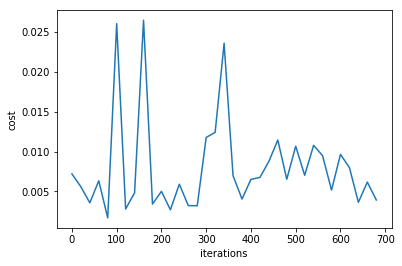

In [96]:
#绘制损失变化函数曲线
def plot_gradient_descent(Loss):
    m=len(Loss)
    Loss=np.array(Loss)
    Loss=Loss.reshape((m,))
    x=[]
    y=[]
    for i in range(m):
        if(i%20==0):
            x.append(i)
            y.append(Loss[i])
    plt.figure()
    plt.plot(x,y)
    plt.xlabel('iterations')
    plt.ylabel('cost')

#画图
plot_gradient_descent(Loss)
plt.show()

In [97]:
def load_one_example():
    # 从上边已加载的测试集中，随机选择一条作为测试数据
    idx = np.random.randint(0, test_data.shape[0])
    idx = -10
    one_data, label = test_data[idx, :-1], test_data[idx, -1]
    # 修改该条数据shape为[1,13]
    one_data =  one_data.reshape([1,-1])

    return one_data, label

In [98]:
# 保存模型参数，文件名为LR_model.pdparams
paddle.save(model.state_dict(), '房价预测/LR_model.pdparams')
print("模型保存成功，模型参数保存在LR_model.pdparams中")

模型保存成功，模型参数保存在LR_model.pdparams中


In [99]:
#参数为保存模型参数的文件地址
model_dict = paddle.load('房价预测/LR_model.pdparams')
model.load_dict(model_dict)
model.eval()

# 参数为数据集的文件地址
one_data, label = load_one_example()
# 将数据转为动态图的variable格式 
one_data = paddle.to_tensor(one_data)
predict = model(one_data)

# 对结果做反归一化处理
predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
# 对label数据做反归一化处理
label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

print("Inference result is {}, the corresponding label is {}".format(predict.numpy(), label))

Inference result is [[1016.65955]], the corresponding label is 850.0
